# Guía 4

Nombre estudiante: Pablo Gómez Paredes  
Nombre profesor: David Medina Ortiz  
Asignatura: Matemáticas para Ciencias de la Computación  
Fecha entrega: 28/11/2025

## 1.1) Introducción: Colección, preparación y justificación del dataset escogido

En la presente guía se analizará un dataset referente a los datos históricos del tiempo en Punta Arenas, abarcando el período desde el 1 de septiembre hasta el 31 de octubre del presente año.  Los descriptores incluidos corresponden principalmente a temperatura, velocidad del viento y presión atmosférica.

La etiqueta _(label)_ que se analizará en función de estos descriptores será un valor binario (0 o 1) construido específicamente para este análisis, indicando si en un día determinado hubo precipitación (1) o no la hubo (0).  Esta decisión permitirá simplificar el análisis, y centrar la exploración estadística en la ocurrencia del fenómeno y en qué factores pueden hacer más probable que ocurra ese fenómeno, más que en su intensidad.

Este dataset se escogió principalmente porque permite trabajar con datos reales, recientes y que además son más de mi interés analizar.   Y por otra parte, también porque el clima de Punta Arenas presenta condiciones particularmente dinámicas —con fuertes variaciones de viento, cambios bruscos de temperatura y frecuencia de precipitaciones— lo que genera un conjunto de datos estadísticamente interesante para estudiar asociaciones y patrones.

Para la obtención del dataset, hubo que instalar la librería _meteostat_ a través del comando pip install.  Esta librería facilita el acceso a registros metereológicos de estaciones oficiales y permite descargar datos fácilmente transformables para su posterior análisis.

In [7]:
# Inclusión de librerías necesarias
from meteostat import Daily, Point
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from datetime import datetime
from auxiliar_functions import *

In [8]:
# Coordenadas de Punta Arenas
punta_arenas = Point(-53.155877, -70.901687)

In [9]:
# Rango de fechas
start = datetime(2025, 9, 1)
end = datetime(2025, 10, 31)

In [10]:
# Descarga de los datos
data = Daily(punta_arenas, start, end)
df = data.fetch()

## 1.2) Descripción de metadatos y composición del dataset (descripción general y descripción de variables)

En las siguientes celdas se hará el código que permitirá describir los metadatos y la composición del dataset, y también luego se explicará.

In [11]:
# Primeras filas del dataset
df.head(10)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2025-09-01,4.0,1.0,7.0,0.4,<NA>,<NA>,31.7,<NA>,1001.1,<NA>
2025-09-02,1.4,-1.0,4.0,0.0,<NA>,<NA>,33.2,<NA>,996.5,<NA>
2025-09-03,2.4,-1.0,5.0,0.0,<NA>,<NA>,33.8,<NA>,1014.6,<NA>
2025-09-04,5.9,3.0,9.0,0.0,<NA>,<NA>,27.1,<NA>,1022.4,<NA>
2025-09-05,7.4,5.0,10.0,0.4,<NA>,<NA>,36.2,<NA>,1016.2,<NA>
2025-09-06,6.8,5.0,10.0,0.0,<NA>,<NA>,33.8,<NA>,1011.9,<NA>
2025-09-07,6.3,4.0,10.0,0.0,<NA>,<NA>,35.6,<NA>,1006.1,<NA>
2025-09-08,5.4,2.0,9.0,0.4,<NA>,<NA>,19.5,<NA>,1010.7,<NA>
2025-09-09,5.2,4.0,6.0,3.6,<NA>,<NA>,29.0,<NA>,1003.5,<NA>


In [12]:
# Tamaño del dataset
df.shape

(61, 10)

In [13]:
# Tipos de metadatos
df.dtypes

tavg    Float64
tmin    Float64
tmax    Float64
prcp    Float64
snow    Float64
wdir    Float64
wspd    Float64
wpgt    Float64
pres    Float64
tsun    Float64
dtype: object

El dataset en su forma original contiene 61 ejemplos y 10 descriptores, todos del tipo numérico, los cuales podrán actuar como variables predictoras en el análisis. Estos descriptores son:

* tavg: La temperatura media de un día (°C).
* tmin: La temperatura mínima alcanzada durante un día (°C).
* tmax: La temperatura máxima alcanzada durante un día (°C).
* prcp: La precipitación durante un día (mm)._
* snow: La precipitación en forma de nieve durante un día (mm).
* wdir: Dirección del viento (°).
* wspd: Rapidez media del viento durante un día (km/h).
* wpgt: Rapidez máxima de las rachas de viento (km/h).
* pres: Presión atmosférica media a nivel del mar (hPa).
* tsun: Horas de sol diarias (h).

Nota: Incluso podrían ser 11 descriptores si consideramos también a la fecha como un descriptor más.

El dataset no incluye originalmente una etiqueta _(label)_ para realizar análisis.  Por este motivo, y dado que el objetivo de la guía es investigar asociaciones entre descriptores y un fenómeno de interés, se generará una nueva etiqueta binaria basada en la ocurrencia de precipitación.  Específicamente, la columna prcp será recodificada para producir una variable 0/1 que indique si en un día determinado hubo lluvia (1) o no la hubo (0).

Al observar los descriptores, también se aprecia a simple vista que algunos presentan una cantidad importante de valores faltantes. Para evaluar su impacto, se realizará un recuento formal de datos nulos por columna. Como criterio general — común en análisis exploratorio — si un descriptor presenta más de un 30% de valores faltantes, la columna será eliminada debido a su baja utilidad informativa. En caso de porcentajes menores, y si la variable resulta relevante para el análisis, sus valores faltantes se imputarán mediante la mediana, considerando que se trata de variables numéricas potencialmente afectadas por asimetría.

Cabe destacar que, al tratarse de datos meteorológicos históricos, sería posible completar los valores faltantes consultando registros de otras estaciones meteorológicas. Sin embargo, dicha reconstrucción iría más allá del propósito de esta guía, cuyo objetivo es practicar análisis exploratorio y tratamiento estadístico de datos tal como se presentan.

## 2.1) EDA - Parte I: Identificación de nulos y resumen estadístico.

En las siguientes celdas se hará el análisis de los datos nulos y cómo tratarlos, y también un resumen estadístico.  En esta sección ya se tendrá el dataset definitivo que se utilizará para hacer lo que sigue.

In [14]:
# Se genera el recuento de nulos para cada uno de los descriptores
df_count_nulls = generate_df_count_nulls(df=df)
df_count_nulls

,count_nulls,pct_nulls
tavg,0,0.0
tmin,0,0.0
tmax,0,0.0
prcp,0,0.0
snow,61,100.0
wdir,61,100.0
wspd,0,0.0
wpgt,61,100.0
pres,0,0.0
tsun,61,100.0


In [15]:
columns_to_delete =  []

# Se eliminan las columnas que tienen al menos un 30% de datos nulos, en caso contrario habría que hacer imputación por medio de la mediana
for row in df_count_nulls.index:
    if df_count_nulls["pct_nulls"][row] >= 30.0:
        columns_to_delete.append(row)

df = df.drop(columns=columns_to_delete)

df.head(10)  # Se muestran las primeras filas (registros) del dataset

,tavg,tmin,tmax,prcp,wspd,pres
time,,,,,,
2025-09-01,4.0,1.0,7.0,0.4,31.7,1001.1
2025-09-02,1.4,-1.0,4.0,0.0,33.2,996.5
2025-09-03,2.4,-1.0,5.0,0.0,33.8,1014.6
2025-09-04,5.9,3.0,9.0,0.0,27.1,1022.4
2025-09-05,7.4,5.0,10.0,0.4,36.2,1016.2
2025-09-06,6.8,5.0,10.0,0.0,33.8,1011.9
2025-09-07,6.3,4.0,10.0,0.0,35.6,1006.1
2025-09-08,5.4,2.0,9.0,0.4,19.5,1010.7
2025-09-09,5.2,4.0,6.0,3.6,29.0,1003.5


In [16]:
df = df.rename(columns={"prcp": "mm"})
df["prcp"] = df["mm"].apply(lambda x: 0 if x == 0.0 else 1)  # Aquí se genera el label (originalmente no venía)
df = df.drop(columns=["mm"])
df

,tavg,tmin,tmax,wspd,pres,prcp
time,,,,,,
2025-09-01,4.0,1.0,7.0,31.7,1001.1,1
2025-09-02,1.4,-1.0,4.0,33.2,996.5,0
2025-09-03,2.4,-1.0,5.0,33.8,1014.6,0
2025-09-04,5.9,3.0,9.0,27.1,1022.4,0
2025-09-05,7.4,5.0,10.0,36.2,1016.2,1
...,...,...,...,...,...,...
2025-10-27,6.5,-2.0,15.0,9.8,1024.2,0
2025-10-28,8.2,4.0,12.0,11.9,1011.8,0
2025-10-29,11.4,8.0,16.0,27.6,1006.7,0


In [17]:
# Verificamos que el dataset nuevo no tiene datos nulos
new_df_count_nulls = generate_df_count_nulls(df=df)
new_df_count_nulls

,count_nulls,pct_nulls
tavg,0,0.0
tmin,0,0.0
tmax,0,0.0
wspd,0,0.0
pres,0,0.0
prcp,0,0.0


### Explicación del nuevo dataset

El dataset nuevo ahora tiene solo 6 variables: 5 predictivas que son numéricas y continuas (tavg, tmin, tmax, wspd y pres) y 1 variable binaria que está actuando como _label_ (prcp).

Ahora, como se puede apreciar también, el dataset ya no tiene ningún dato nulo.


### Resumen estadístico

In [18]:
# Descriptores numéricos reales
predictors = df[["tavg", "tmin", "tmax", "wspd", "pres"]]

df_descriptive = predictors.describe().T
df_descriptive = df_descriptive.apply(pd.to_numeric, errors='coerce')
df_descriptive["mean"] = df_descriptive["mean"].round(2)
df_descriptive["std"] = df_descriptive["std"].round(2)
df_descriptive


,count,mean,std,min,25%,50%,75%,max
tavg,61.0,6.13,2.02,1.4,4.8,6.4,7.2,11.4
tmin,61.0,2.77,2.35,-3.0,1.0,3.0,4.0,8.0
tmax,61.0,9.89,2.69,4.0,8.0,10.0,11.0,17.0
wspd,61.0,26.08,7.71,8.0,20.1,27.1,32.1,41.7
pres,61.0,1001.12,11.03,973.0,993.5,999.3,1009.2,1024.8


In [19]:
df["prcp"].value_counts()

prcp
0    37
1    24
Name: count, dtype: int64

## 2.2) EDA - Parte II: Identificación de _outliers_

In [20]:
# Se hace un data frame para los rangos de los outliers
df_outlier_ranges = pd.DataFrame(columns=["min", "max"])

for var in predictors:
    q1 = df_descriptive["25%"][var]
    q3 = df_descriptive["75%"][var]
    IQR = q3 - q1
    min_val, max_val = get_range_outlier(q1, q3, IQR)
    df_outlier_ranges.loc[var, "min"] = min_val
    df_outlier_ranges.loc[var, "max"] = max_val

df_outlier_ranges


,min,max
tavg,1.2,10.8
tmin,-3.5,8.5
tmax,3.5,15.5
wspd,2.1,50.1
pres,969.95,1032.75


## 3) Decisión sobre _outliers_

In [21]:
# Creamos el DataFrame vacío con las columnas que queremos
outlier_summary = pd.DataFrame(columns=["n_outliers", "pct_outliers"])

for var in predictors:
    # Límites inferior y superior del rango "no outlier"
    low = df_outlier_ranges.loc[var, "min"]
    high = df_outlier_ranges.loc[var, "max"]
    
    # Máscara booleana para detectar outliers
    mask_outliers = (df[var] < low) | (df[var] > high)
    
    # Cantidad y porcentaje de outliers
    n_out = mask_outliers.sum()
    pct_out = (n_out / len(df)) * 100
    
    # Guardamos en una fila cuyo índice es el nombre de la variable
    outlier_summary.loc[var, "n_outliers"] = n_out
    outlier_summary.loc[var, "pct_outliers"] = round(pct_out, 2)

outlier_summary


,n_outliers,pct_outliers
tavg,2,3.28
tmin,0,0.0
tmax,2,3.28
wspd,0,0.0
pres,0,0.0


Como se pudo observar, solo hay 4 _outliers_ en total en el dataset: 2 de ellos corresponden a la variable tavg y los otros 2 a la variable tmax, de modo que las demás variables no poseen ningún _outlier_.

Además, las dos variables que sí poseen _outliers_ tienen un porcentaje bajo de de datos atípicos: solo un 3.28%.

Al ser bajo el porcentaje de _outliers_, la decisión de momento será de conservar esos _outliers_, pero para confirmarlo, a continuación se hallarán exactamente cuáles son los registros que contienen esos datos atípicos, y se analizarán sus valores, para tomar la decisión final.

In [22]:
rows = []

for var in predictors:
    low = df_outlier_ranges.loc[var, "min"]
    high = df_outlier_ranges.loc[var, "max"]
    mask_outliers = (df[var] < low) | (df[var] > high)

    for idx in df.index[mask_outliers]:
        rows.append({
            "variable": var,
            "index": idx,
            "value": df.loc[idx, var]
        })

df_outlier_detail = pd.DataFrame(rows)
df_outlier_detail


,variable,index,value
0,tavg,2025-10-29,11.4
1,tavg,2025-10-30,11.2
2,tmax,2025-10-29,16.0
3,tmax,2025-10-30,17.0


### Decisión final

Al ver que los valores no se alejan demasiado del mínimo valor para _outlier_ grande, se tomará la decisión de mantener esos _outliers_.

Esta decisión se tomará, sobre todo teniendo en cuenta que representan días inusualmente cálidos pero dentro de lo esperado para días lindos de fines de octubre en Punta Arenas.

## 4) Visualización estadística y matrices de correlación

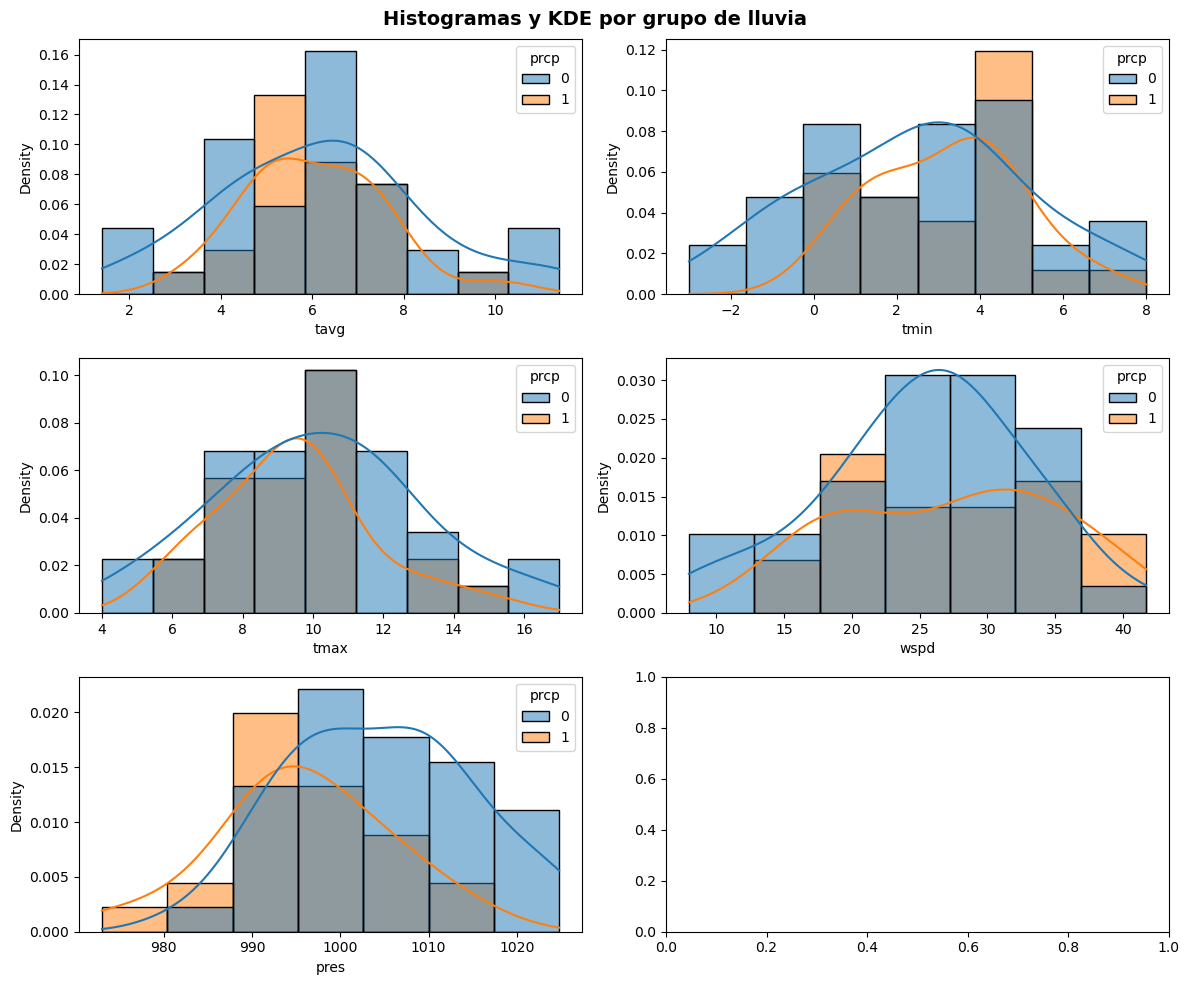

In [23]:
cols = predictors

fig, axis = plt.subplots(3, 2, figsize=(12, 10))
i = j = 0

for column in cols:
    sns.histplot(
        data=df,
        x=column,
        stat="density",
        kde=True,
        hue="prcp",  # 0 = no lluvia, 1 = lluvia
        ax=axis[i][j]
    )
    axis[i][j].set_xlabel(column)
    j += 1
    if j > 1:
        j = 0
        i += 1

plt.suptitle("Histogramas y KDE por grupo de lluvia", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


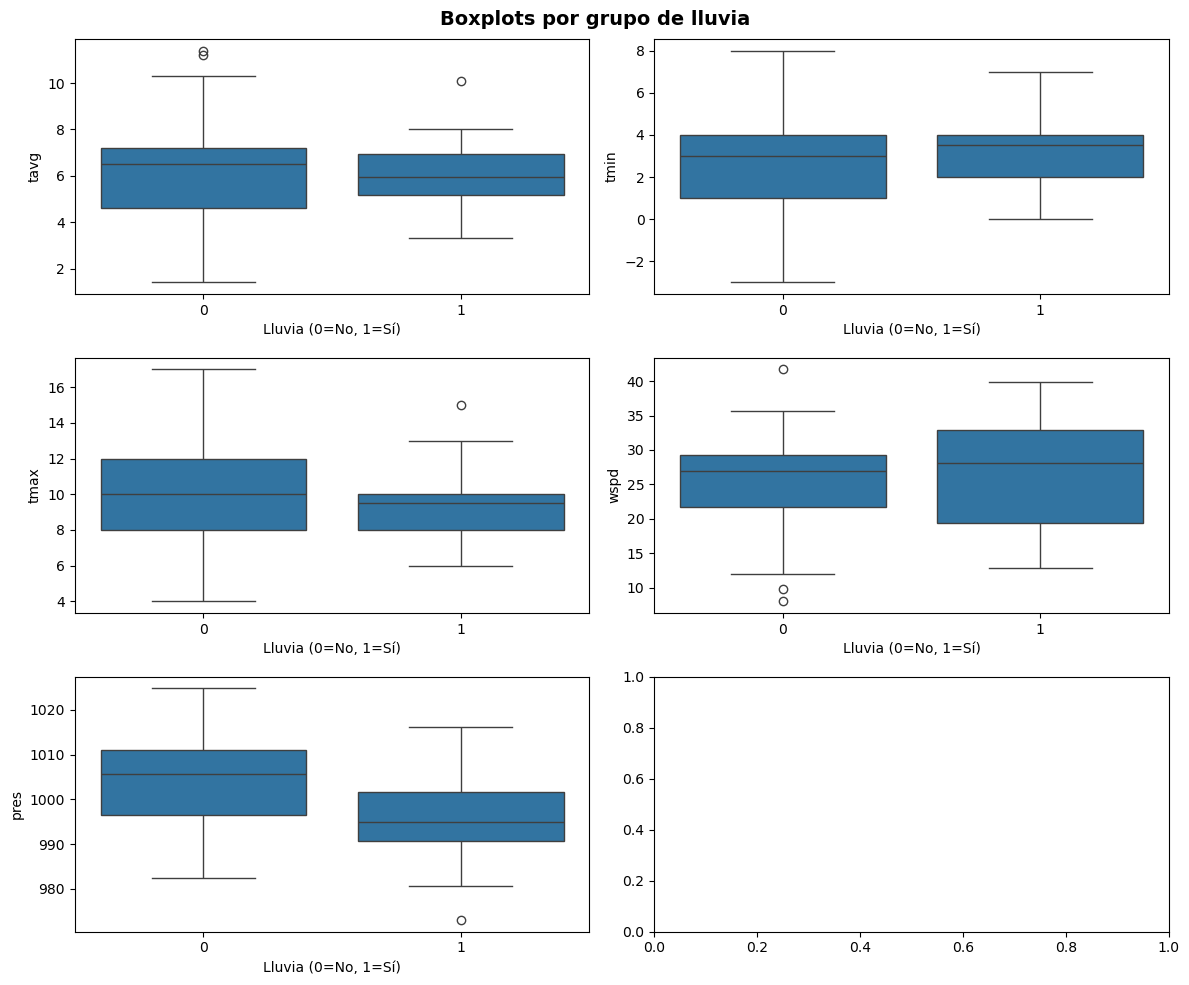

In [24]:
fig, axis = plt.subplots(3, 2, figsize=(12, 10))
i = j = 0

for column in cols:
    sns.boxplot(
        data=df,
        x="prcp",
        y=column,
        ax=axis[i][j]
    )
    axis[i][j].set_xlabel("Lluvia (0=No, 1=Sí)")
    axis[i][j].set_ylabel(column)
    j += 1
    if j > 1:
        j = 0
        i += 1

plt.suptitle("Boxplots por grupo de lluvia", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


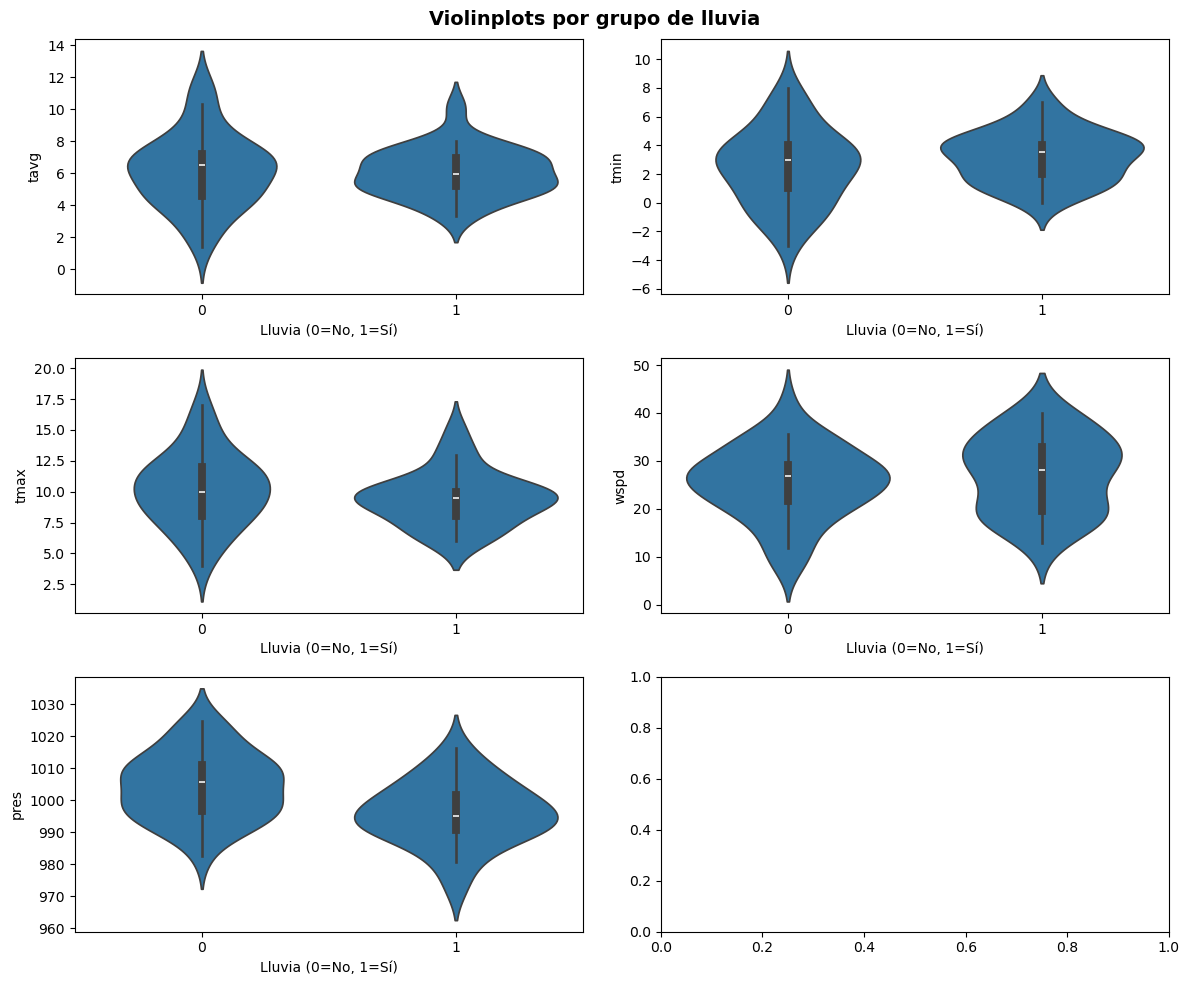

In [25]:
fig, axis = plt.subplots(3, 2, figsize=(12, 10))
i = j = 0

for column in cols:
    sns.violinplot(
        data=df,
        x="prcp",
        y=column,
        ax=axis[i][j]
    )
    axis[i][j].set_xlabel("Lluvia (0=No, 1=Sí)")
    axis[i][j].set_ylabel(column)
    j += 1
    if j > 1:
        j = 0
        i += 1

plt.suptitle("Violinplots por grupo de lluvia", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


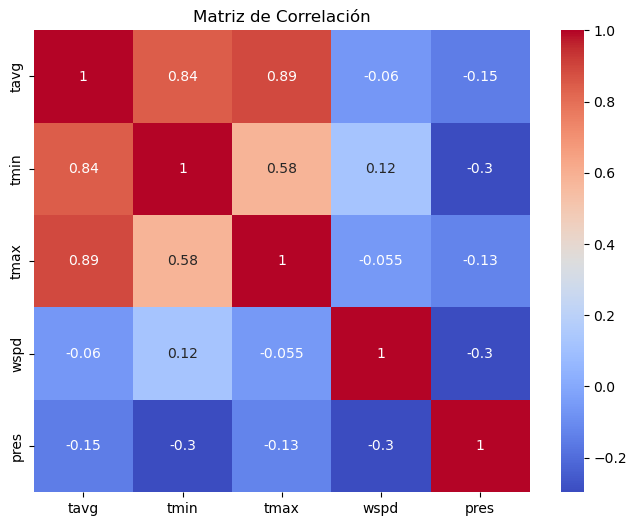

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(predictors.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()



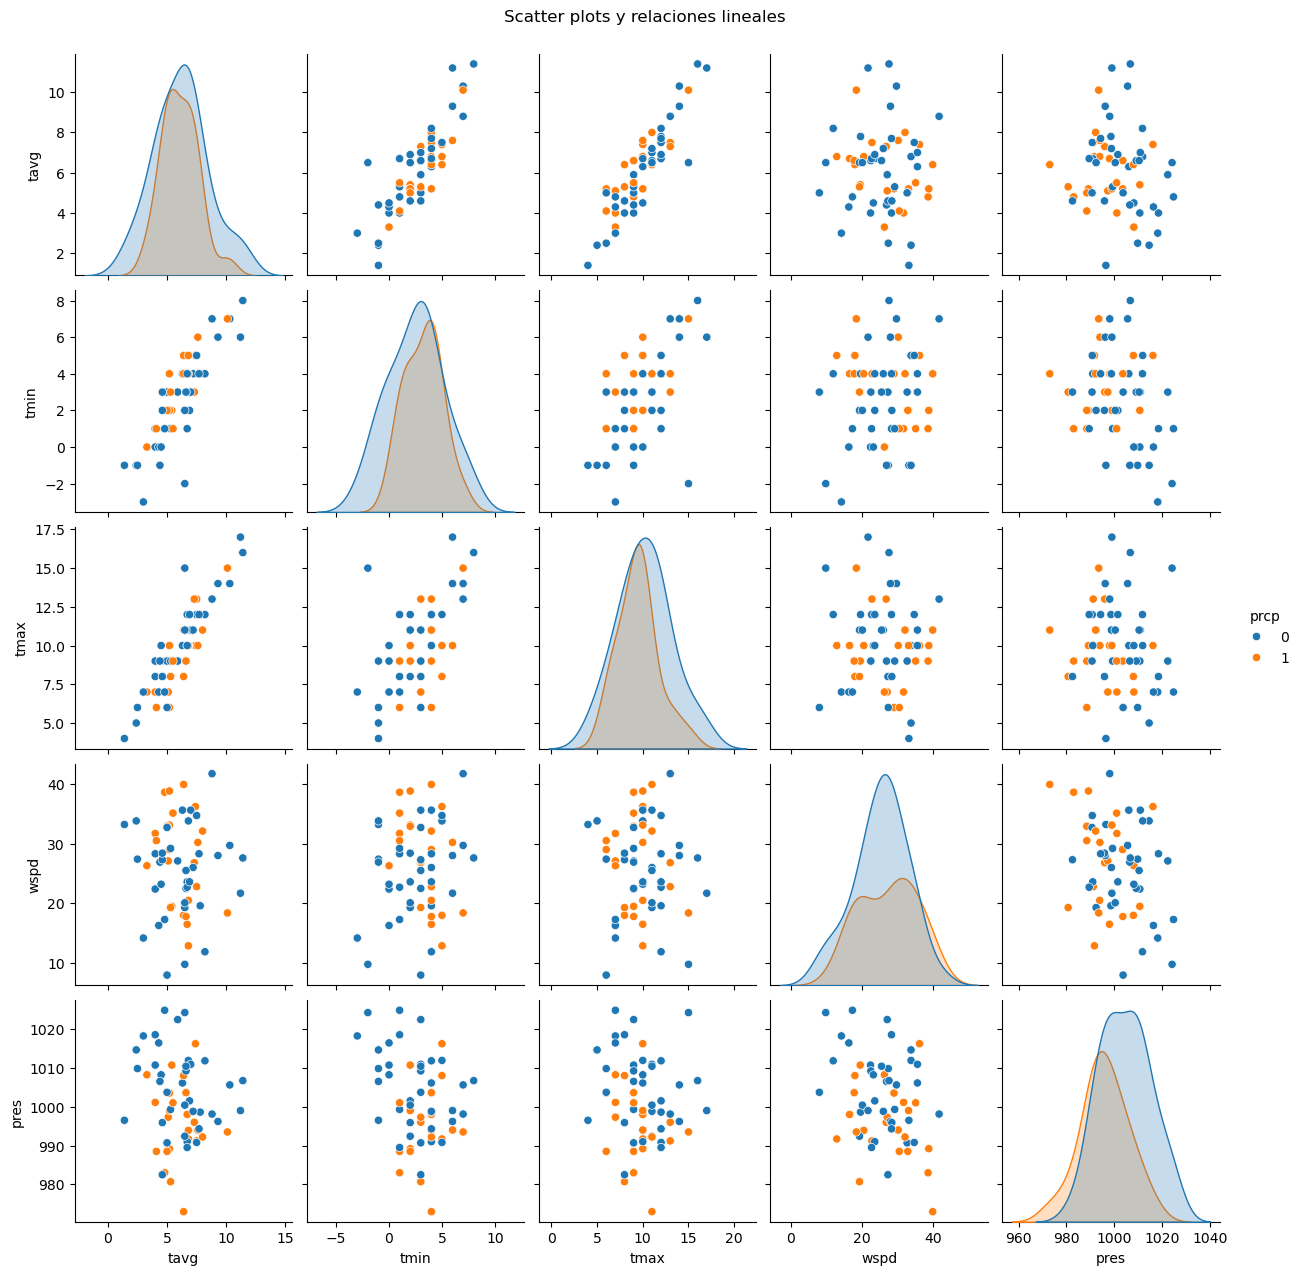

In [27]:
predictor_cols = predictors.columns.tolist()

sns.pairplot(df[predictor_cols + ["prcp"]], hue="prcp")
plt.suptitle("Scatter plots y relaciones lineales", y=1.02)
plt.show()



## 5) Preparación de datos y ajuste de PCA completo

In [39]:
# Subdataframes
y = df["prcp"].values
X = df.drop(columns=["prcp"])

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

pca_instance = PCA(n_components=3, random_state=42)
pca_instance.fit(X_scaler)
pca_instance.transform(X_scaler)

array([[-1.61685613e+00,  8.51384874e-01,  2.76039907e-01],
       [-3.38738957e+00,  1.61744854e+00, -1.43404974e-01],
       [-3.21719890e+00,  4.68258759e-01,  1.18708722e+00],
       [-5.86532009e-01, -1.05025647e+00,  1.47246029e+00],
       [ 6.98982512e-01,  5.02215358e-02,  1.99734722e+00],
       [ 5.86840401e-01,  1.22164312e-01,  1.47562960e+00],
       [ 3.17787259e-01,  6.35143724e-01,  1.20719234e+00],
       [-7.91616729e-01, -1.08573746e+00, -1.71681805e-02],
       [-8.10920307e-01,  5.36533485e-01,  2.76055065e-01],
       [-1.21279958e+00, -1.48622793e+00, -1.59080723e+00],
       [ 5.49872558e-02, -9.73803324e-01, -2.58772425e-01],
       [ 4.95688438e-01, -7.38361024e-01, -9.99398989e-01],
       [ 1.50423687e+00, -2.56837471e-02, -7.65333378e-01],
       [ 1.13877891e+00,  5.49650617e-02, -1.22447668e-01],
       [-7.66765275e-01,  6.17518815e-01, -2.96045575e-01],
       [-2.22146457e+00, -5.17653070e-02,  2.23401241e-01],
       [-1.75399380e+00, -5.53802169e-01

In [40]:
pca_instance.n_components_

3

In [41]:
pca_instance.explained_variance_ratio_

array([0.52387209, 0.26054498, 0.13467278])

In [42]:
sum(pca_instance.explained_variance_ratio_)

np.float64(0.9190898515315439)

In [45]:
df_matrix_pca = pd.DataFrame(data=pca_instance.transform(X_scaler), columns=["p_" + str(i) for i in range(pca_instance.n_components_)])
df_matrix_pca

,p_0,p_1,p_2
0,-1.616856,0.851385,0.276040
1,-3.387390,1.617449,-0.143405
2,-3.217199,0.468259,1.187087
3,-0.586532,-1.050256,1.472460
4,0.698983,0.050222,1.997347
...,...,...,...
56,-0.480253,-3.453873,0.184267
57,1.074473,-2.243354,-0.360317
58,3.964507,-0.862970,1.029052
59,3.751541,-1.102043,-0.020567


In [46]:
df_matrix_pca.corr()

,p_0,p_1,p_2
p_0,1.000000e+00,-2.453329e-16,7.160513e-17
p_1,-2.453329e-16,1.000000e+00,4.445189e-17
p_2,7.160513e-17,4.445189e-17,1.000000e+00


## Declaración de uso de IA

Se declara el uso de asistentes de inteligencia artificial - principalmente Copilot y ChatGPT - para mejorar un poquito la redacción de las explicaciones en algunas partes así como también la elaboración del código en algunas partes más complicadas.  Esto después igual fue verificado y analizado.